# Import Libraries

In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

# CUDA?

print(torch.__version__)

cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

2.0.0.dev20230127+cu118
CUDA Available? True


## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise. 


In [2]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [3]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

# Dataloader Arguments & Test/Train Dataloaders


In [4]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


# The model
Let's start with the model we first saw

In [5]:
from model import Net

2.0.0.dev20230127+cu118
CUDA Available? True


# Model Params
Can't emphasize on how important viewing Model Summary is. 
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [6]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net(norm_type="nn.BatchNorm2d").to(device)
summary(model, input_size=(1, 28, 28))

Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.


cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 26, 26]             144
              ReLU-2           [-1, 16, 26, 26]               0
       BatchNorm2d-3           [-1, 16, 26, 26]              32
           Dropout-4           [-1, 16, 26, 26]               0
            Conv2d-5           [-1, 32, 24, 24]           4,608
              ReLU-6           [-1, 32, 24, 24]               0
       BatchNorm2d-7           [-1, 32, 24, 24]              64
           Dropout-8           [-1, 32, 24, 24]               0
            Conv2d-9           [-1, 10, 24, 24]             320
        MaxPool2d-10           [-1, 10, 12, 12]               0
           Conv2d-11           [-1, 16, 10, 10]           1,440
             ReLU-12           [-1, 16, 10, 10]               0
      BatchNorm2d-13           [-1, 16, 10, 10]              32
          Dropout-14           [-1

# testing and Testing

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs. 

Let's write test and test functions

In [7]:
from tqdm import tqdm

def test(model, device, test_loader, optimizer, epoch,test_losses=[],test_acc=[]):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)
  return train_losses,train_acc

def test(model, device, test_loader,test_losses=[],test_acc=[]):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))
    return test_losses,test_acc

**Group Normalization**

In [8]:
model =  Net(norm_type="nn.GroupNorm").to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

train_losses_gn = []
test_losses_gn = []
train_acc_gn = []
test_acc_gn = []

EPOCHS = 20
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train_losses_gn,train_acc_gn = train(model, device, train_loader, optimizer, epoch,train_losses_gn,train_acc_gn)
    test_losses_gn ,test_acc_gn = test(model, device, test_loader,test_losses_gn,test_acc_gn)

EPOCH: 0


Loss=0.1700958013534546 Batch_id=468 Accuracy=83.39: 100%|██████████| 469/469 [00:03<00:00, 128.11it/s] 



Test set: Average loss: 0.1153, Accuracy: 9671/10000 (96.71%)

EPOCH: 1


Loss=0.03507306054234505 Batch_id=468 Accuracy=97.08: 100%|██████████| 469/469 [00:04<00:00, 104.83it/s] 



Test set: Average loss: 0.0517, Accuracy: 9857/10000 (98.57%)

EPOCH: 2


Loss=0.03097393363714218 Batch_id=468 Accuracy=97.80: 100%|██████████| 469/469 [00:04<00:00, 105.87it/s] 



Test set: Average loss: 0.0448, Accuracy: 9865/10000 (98.65%)

EPOCH: 3


Loss=0.1555269956588745 Batch_id=468 Accuracy=98.09: 100%|██████████| 469/469 [00:04<00:00, 101.97it/s]  



Test set: Average loss: 0.0398, Accuracy: 9889/10000 (98.89%)

EPOCH: 4


Loss=0.008940919302403927 Batch_id=468 Accuracy=98.37: 100%|██████████| 469/469 [00:04<00:00, 103.10it/s]



Test set: Average loss: 0.0324, Accuracy: 9901/10000 (99.01%)

EPOCH: 5


Loss=0.08105682581663132 Batch_id=468 Accuracy=98.60: 100%|██████████| 469/469 [00:04<00:00, 103.40it/s]  



Test set: Average loss: 0.0274, Accuracy: 9924/10000 (99.24%)

EPOCH: 6


Loss=0.06433757394552231 Batch_id=468 Accuracy=98.60: 100%|██████████| 469/469 [00:04<00:00, 105.20it/s] 



Test set: Average loss: 0.0243, Accuracy: 9927/10000 (99.27%)

EPOCH: 7


Loss=0.006765959318727255 Batch_id=468 Accuracy=98.70: 100%|██████████| 469/469 [00:04<00:00, 105.34it/s] 



Test set: Average loss: 0.0237, Accuracy: 9927/10000 (99.27%)

EPOCH: 8


Loss=0.02107556164264679 Batch_id=468 Accuracy=98.75: 100%|██████████| 469/469 [00:04<00:00, 105.38it/s] 



Test set: Average loss: 0.0270, Accuracy: 9917/10000 (99.17%)

EPOCH: 9


Loss=0.060949504375457764 Batch_id=468 Accuracy=98.88: 100%|██████████| 469/469 [00:04<00:00, 105.02it/s] 



Test set: Average loss: 0.0226, Accuracy: 9930/10000 (99.30%)

EPOCH: 10


Loss=0.03294586017727852 Batch_id=468 Accuracy=98.88: 100%|██████████| 469/469 [00:04<00:00, 104.84it/s]  



Test set: Average loss: 0.0202, Accuracy: 9944/10000 (99.44%)

EPOCH: 11


Loss=0.04657996818423271 Batch_id=468 Accuracy=98.89: 100%|██████████| 469/469 [00:04<00:00, 105.21it/s]  



Test set: Average loss: 0.0197, Accuracy: 9937/10000 (99.37%)

EPOCH: 12


Loss=0.005297218915075064 Batch_id=468 Accuracy=98.98: 100%|██████████| 469/469 [00:04<00:00, 104.77it/s] 



Test set: Average loss: 0.0226, Accuracy: 9931/10000 (99.31%)

EPOCH: 13


Loss=0.036206118762493134 Batch_id=468 Accuracy=99.04: 100%|██████████| 469/469 [00:04<00:00, 105.62it/s] 



Test set: Average loss: 0.0202, Accuracy: 9943/10000 (99.43%)

EPOCH: 14


Loss=0.031378429383039474 Batch_id=468 Accuracy=98.99: 100%|██████████| 469/469 [00:04<00:00, 106.00it/s] 



Test set: Average loss: 0.0247, Accuracy: 9924/10000 (99.24%)

EPOCH: 15


Loss=0.04534490779042244 Batch_id=468 Accuracy=99.00: 100%|██████████| 469/469 [00:04<00:00, 104.81it/s]  



Test set: Average loss: 0.0207, Accuracy: 9945/10000 (99.45%)

EPOCH: 16


Loss=0.01685107871890068 Batch_id=468 Accuracy=98.99: 100%|██████████| 469/469 [00:04<00:00, 106.69it/s]  



Test set: Average loss: 0.0203, Accuracy: 9941/10000 (99.41%)

EPOCH: 17


Loss=0.005247922148555517 Batch_id=468 Accuracy=99.07: 100%|██████████| 469/469 [00:04<00:00, 102.65it/s] 



Test set: Average loss: 0.0176, Accuracy: 9946/10000 (99.46%)

EPOCH: 18


Loss=0.019237082451581955 Batch_id=468 Accuracy=99.03: 100%|██████████| 469/469 [00:04<00:00, 110.45it/s] 



Test set: Average loss: 0.0199, Accuracy: 9944/10000 (99.44%)

EPOCH: 19


Loss=0.015127289108932018 Batch_id=468 Accuracy=99.14: 100%|██████████| 469/469 [00:04<00:00, 105.73it/s] 



Test set: Average loss: 0.0206, Accuracy: 9937/10000 (99.37%)



**Layer Normalization**

In [9]:
model =  Net(norm_type="nn.LayerNorm").to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

train_losses_ln = []
test_losses_ln = []
train_acc_ln = []
test_acc_ln = []

EPOCHS = 20
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train_losses_ln,train_acc_ln = train(model, device, train_loader, optimizer, epoch,train_losses_ln,train_acc_ln)
    test_losses_ln ,test_acc_ln = test(model, device, test_loader,test_losses_ln,test_acc_ln)

EPOCH: 0


Loss=0.1788514256477356 Batch_id=468 Accuracy=85.76: 100%|██████████| 469/469 [00:04<00:00, 105.85it/s] 



Test set: Average loss: 0.1094, Accuracy: 9751/10000 (97.51%)

EPOCH: 1


Loss=0.06682214140892029 Batch_id=468 Accuracy=97.14: 100%|██████████| 469/469 [00:04<00:00, 105.30it/s] 



Test set: Average loss: 0.0608, Accuracy: 9844/10000 (98.44%)

EPOCH: 2


Loss=0.09838201850652695 Batch_id=468 Accuracy=97.87: 100%|██████████| 469/469 [00:04<00:00, 105.44it/s] 



Test set: Average loss: 0.0509, Accuracy: 9851/10000 (98.51%)

EPOCH: 3


Loss=0.051419079303741455 Batch_id=468 Accuracy=98.26: 100%|██████████| 469/469 [00:04<00:00, 106.38it/s]



Test set: Average loss: 0.0371, Accuracy: 9888/10000 (98.88%)

EPOCH: 4


Loss=0.10342610627412796 Batch_id=468 Accuracy=98.39: 100%|██████████| 469/469 [00:04<00:00, 103.24it/s] 



Test set: Average loss: 0.0418, Accuracy: 9883/10000 (98.83%)

EPOCH: 5


Loss=0.057847242802381516 Batch_id=468 Accuracy=98.51: 100%|██████████| 469/469 [00:04<00:00, 106.30it/s]



Test set: Average loss: 0.0317, Accuracy: 9905/10000 (99.05%)

EPOCH: 6


Loss=0.04478301480412483 Batch_id=468 Accuracy=98.61: 100%|██████████| 469/469 [00:04<00:00, 105.51it/s] 



Test set: Average loss: 0.0304, Accuracy: 9916/10000 (99.16%)

EPOCH: 7


Loss=0.009326128289103508 Batch_id=468 Accuracy=98.69: 100%|██████████| 469/469 [00:04<00:00, 105.91it/s] 



Test set: Average loss: 0.0268, Accuracy: 9924/10000 (99.24%)

EPOCH: 8


Loss=0.042822521179914474 Batch_id=468 Accuracy=98.76: 100%|██████████| 469/469 [00:04<00:00, 106.03it/s]



Test set: Average loss: 0.0242, Accuracy: 9925/10000 (99.25%)

EPOCH: 9


Loss=0.010212224908173084 Batch_id=468 Accuracy=98.84: 100%|██████████| 469/469 [00:04<00:00, 106.74it/s] 



Test set: Average loss: 0.0216, Accuracy: 9939/10000 (99.39%)

EPOCH: 10


Loss=0.007180590182542801 Batch_id=468 Accuracy=98.94: 100%|██████████| 469/469 [00:04<00:00, 107.84it/s] 



Test set: Average loss: 0.0302, Accuracy: 9912/10000 (99.12%)

EPOCH: 11


Loss=0.007356097921729088 Batch_id=468 Accuracy=98.94: 100%|██████████| 469/469 [00:04<00:00, 104.01it/s]



Test set: Average loss: 0.0267, Accuracy: 9921/10000 (99.21%)

EPOCH: 12


Loss=0.06012613698840141 Batch_id=468 Accuracy=98.96: 100%|██████████| 469/469 [00:04<00:00, 104.47it/s]  



Test set: Average loss: 0.0256, Accuracy: 9926/10000 (99.26%)

EPOCH: 13


Loss=0.08865159749984741 Batch_id=468 Accuracy=98.97: 100%|██████████| 469/469 [00:04<00:00, 105.36it/s]  



Test set: Average loss: 0.0232, Accuracy: 9932/10000 (99.32%)

EPOCH: 14


Loss=0.04173095524311066 Batch_id=468 Accuracy=99.04: 100%|██████████| 469/469 [00:04<00:00, 105.95it/s]  



Test set: Average loss: 0.0255, Accuracy: 9924/10000 (99.24%)

EPOCH: 15


Loss=0.008587215095758438 Batch_id=468 Accuracy=99.05: 100%|██████████| 469/469 [00:04<00:00, 104.18it/s] 



Test set: Average loss: 0.0236, Accuracy: 9933/10000 (99.33%)

EPOCH: 16


Loss=0.07334709167480469 Batch_id=468 Accuracy=99.11: 100%|██████████| 469/469 [00:04<00:00, 106.55it/s]  



Test set: Average loss: 0.0292, Accuracy: 9905/10000 (99.05%)

EPOCH: 17


Loss=0.05959372594952583 Batch_id=468 Accuracy=99.04: 100%|██████████| 469/469 [00:04<00:00, 106.55it/s]  



Test set: Average loss: 0.0211, Accuracy: 9933/10000 (99.33%)

EPOCH: 18


Loss=0.008088494651019573 Batch_id=468 Accuracy=99.11: 100%|██████████| 469/469 [00:04<00:00, 104.59it/s] 



Test set: Average loss: 0.0211, Accuracy: 9938/10000 (99.38%)

EPOCH: 19


Loss=0.022376621142029762 Batch_id=468 Accuracy=99.19: 100%|██████████| 469/469 [00:04<00:00, 105.43it/s] 



Test set: Average loss: 0.0222, Accuracy: 9930/10000 (99.30%)



**L1 Regularization + Batch Normalization**
 

Estimation of Regularisation Coefficient - lambda_l1

Train for one epoch
Get the loss function and sum of model parameters
To make addition term as 0.1*loss , find lambda_l1 = 0.1*loss/sum of parameters

In [10]:
model =  Net(norm_type="nn.BatchNorm2d").to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

EPOCHS = 1
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

EPOCH: 0


Loss=0.10131516307592392 Batch_id=468 Accuracy=87.76: 100%|██████████| 469/469 [00:04<00:00, 104.85it/s] 



Test set: Average loss: 0.0626, Accuracy: 9832/10000 (98.32%)



In [11]:
loss=0.15165962278842926
sum_params = 0

for param in model.parameters():
    sum_params = sum_params + param.abs().sum()

lambda_l1_tensor = (loss*0.1)/sum_params

lambda_l1 = float(lambda_l1_tensor.cpu().detach().numpy())

from torch.optim.lr_scheduler import StepLR

model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9,weight_decay=lambda_l1)

train_losses_bn = []
test_losses_bn = []
train_acc_bn = []
test_acc_bn = []

EPOCHS = 20
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train_losses_bn,train_acc_bn = train(model, device, train_loader, optimizer, epoch,train_losses_bn,train_acc_bn)
    test_losses_bn ,test_acc_bn = test(model, device, test_loader,test_losses_bn,test_acc_bn)

EPOCH: 0


Loss=0.20447146892547607 Batch_id=468 Accuracy=87.68: 100%|██████████| 469/469 [00:04<00:00, 106.49it/s]



Test set: Average loss: 0.0738, Accuracy: 9798/10000 (97.98%)

EPOCH: 1


Loss=0.17933958768844604 Batch_id=468 Accuracy=97.66: 100%|██████████| 469/469 [00:04<00:00, 108.67it/s] 



Test set: Average loss: 0.0461, Accuracy: 9874/10000 (98.74%)

EPOCH: 2


Loss=0.04661265388131142 Batch_id=468 Accuracy=98.11: 100%|██████████| 469/469 [00:04<00:00, 103.97it/s] 



Test set: Average loss: 0.0354, Accuracy: 9898/10000 (98.98%)

EPOCH: 3


Loss=0.058797139674425125 Batch_id=468 Accuracy=98.43: 100%|██████████| 469/469 [00:04<00:00, 104.26it/s]



Test set: Average loss: 0.0292, Accuracy: 9909/10000 (99.09%)

EPOCH: 4


Loss=0.0373464934527874 Batch_id=468 Accuracy=98.50: 100%|██████████| 469/469 [00:04<00:00, 104.70it/s]  



Test set: Average loss: 0.0261, Accuracy: 9917/10000 (99.17%)

EPOCH: 5


Loss=0.09300891309976578 Batch_id=468 Accuracy=98.60: 100%|██████████| 469/469 [00:04<00:00, 103.45it/s] 



Test set: Average loss: 0.0260, Accuracy: 9924/10000 (99.24%)

EPOCH: 6


Loss=0.03140290454030037 Batch_id=468 Accuracy=98.71: 100%|██████████| 469/469 [00:04<00:00, 104.42it/s] 



Test set: Average loss: 0.0218, Accuracy: 9929/10000 (99.29%)

EPOCH: 7


Loss=0.037096090614795685 Batch_id=468 Accuracy=98.81: 100%|██████████| 469/469 [00:04<00:00, 106.39it/s] 



Test set: Average loss: 0.0265, Accuracy: 9923/10000 (99.23%)

EPOCH: 8


Loss=0.01502016931772232 Batch_id=468 Accuracy=98.80: 100%|██████████| 469/469 [00:04<00:00, 105.55it/s]  



Test set: Average loss: 0.0239, Accuracy: 9930/10000 (99.30%)

EPOCH: 9


Loss=0.033571887761354446 Batch_id=468 Accuracy=98.90: 100%|██████████| 469/469 [00:04<00:00, 104.16it/s] 



Test set: Average loss: 0.0227, Accuracy: 9928/10000 (99.28%)

EPOCH: 10


Loss=0.05936077609658241 Batch_id=468 Accuracy=98.91: 100%|██████████| 469/469 [00:04<00:00, 104.89it/s]  



Test set: Average loss: 0.0228, Accuracy: 9930/10000 (99.30%)

EPOCH: 11


Loss=0.0034905781503766775 Batch_id=468 Accuracy=98.95: 100%|██████████| 469/469 [00:04<00:00, 103.20it/s]



Test set: Average loss: 0.0236, Accuracy: 9930/10000 (99.30%)

EPOCH: 12


Loss=0.15447403490543365 Batch_id=468 Accuracy=98.99: 100%|██████████| 469/469 [00:05<00:00, 92.00it/s]   



Test set: Average loss: 0.0215, Accuracy: 9934/10000 (99.34%)

EPOCH: 13


Loss=0.008796652778983116 Batch_id=468 Accuracy=98.94: 100%|██████████| 469/469 [00:05<00:00, 82.30it/s]  



Test set: Average loss: 0.0196, Accuracy: 9945/10000 (99.45%)

EPOCH: 14


Loss=0.035387810319662094 Batch_id=468 Accuracy=99.08: 100%|██████████| 469/469 [00:05<00:00, 84.82it/s]  



Test set: Average loss: 0.0224, Accuracy: 9932/10000 (99.32%)

EPOCH: 15


Loss=0.0333925299346447 Batch_id=468 Accuracy=99.07: 100%|██████████| 469/469 [00:05<00:00, 83.72it/s]    



Test set: Average loss: 0.0199, Accuracy: 9940/10000 (99.40%)

EPOCH: 16


Loss=0.04041722044348717 Batch_id=468 Accuracy=99.07: 100%|██████████| 469/469 [00:05<00:00, 85.35it/s]   



Test set: Average loss: 0.0208, Accuracy: 9939/10000 (99.39%)

EPOCH: 17


Loss=0.08062469214200974 Batch_id=468 Accuracy=99.07: 100%|██████████| 469/469 [00:05<00:00, 85.28it/s]   



Test set: Average loss: 0.0218, Accuracy: 9931/10000 (99.31%)

EPOCH: 18


Loss=0.018479030579328537 Batch_id=468 Accuracy=99.12: 100%|██████████| 469/469 [00:05<00:00, 81.62it/s]  



Test set: Average loss: 0.0210, Accuracy: 9934/10000 (99.34%)

EPOCH: 19


Loss=0.06257187575101852 Batch_id=468 Accuracy=99.08: 100%|██████████| 469/469 [00:05<00:00, 83.09it/s]   



Test set: Average loss: 0.0192, Accuracy: 9945/10000 (99.45%)



**Plots**

Text(0.5, 1.0, 'Test Accuracy')

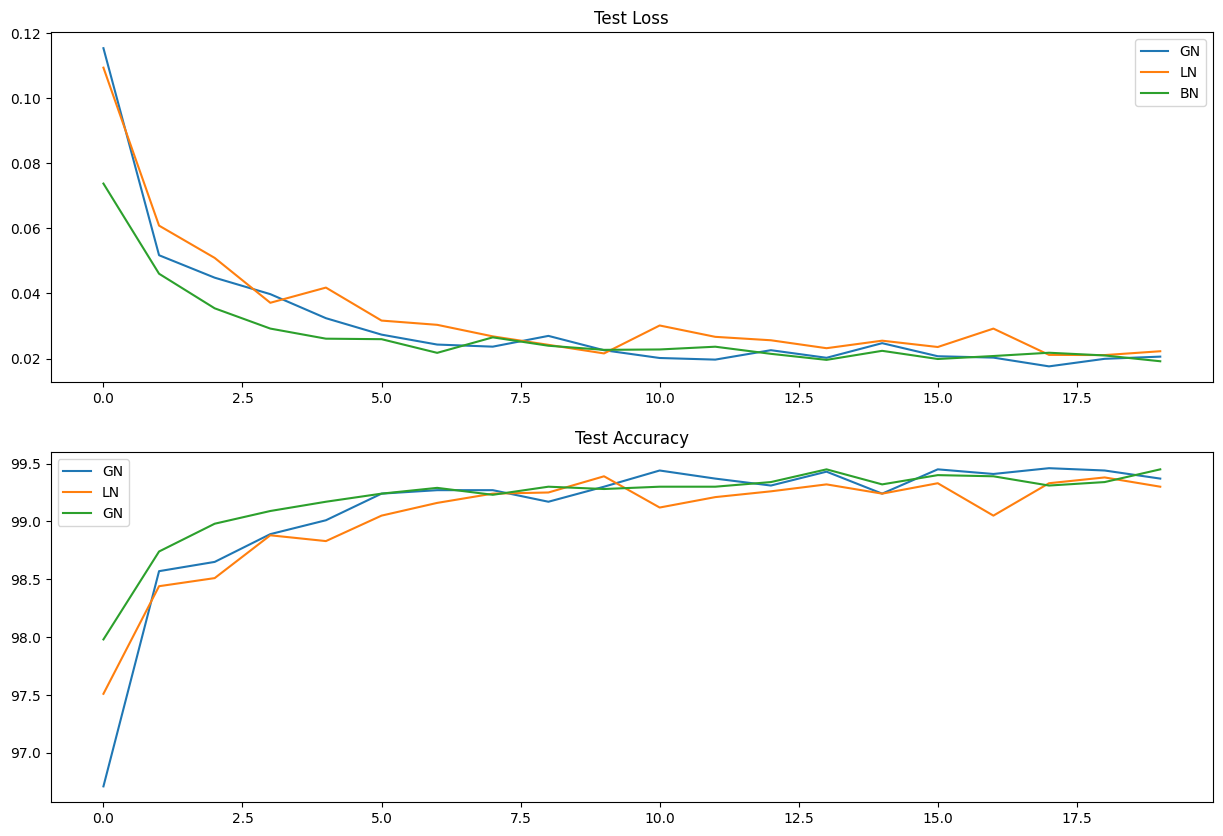

In [14]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2,1,figsize=(15,10))

test_losses_gn = torch.tensor(test_losses_gn, device = 'cpu')
test_losses_ln = torch.tensor(test_losses_ln, device = 'cpu')
test_losses_bn = torch.tensor(test_losses_bn, device = 'cpu')

axs[0].plot(test_losses_gn,label ='GN')
axs[0].plot(test_losses_ln,label ='LN')
axs[0].plot(test_losses_bn,label ='BN')
axs[0].legend()
axs[0].set_title("Test Loss")


axs[1].plot(test_acc_gn,label ='GN')
axs[1].plot(test_acc_ln,label ='LN')
axs[1].plot(test_acc_bn,label ='GN')
axs[1].legend()
axs[1].set_title("Test Accuracy")